In [1]:
import pandas as pd
import numpy as np
import unicodedata
from nltk.tokenize import sent_tokenize #tokenizes sentences
from nltk.tokenize import word_tokenize #tokenizes words
from nltk.corpus import stopwords
import string
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk import pos_tag #tags the parts of speech.  VB=Verbs
from nltk import RegexpParser
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split,  KFold
punctuation_ = set(string.punctuation)
stopwords_ = set(stopwords.words('english'))
import matplotlib.pyplot as plt
import scipy.stats as scs
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

In [2]:
acnh=pd.read_csv('../archive/animal_crossing_dataset.csv')
acnh.columns

Index(['subreddit', 'id', 'title', 'ups', 'downs', 'upvote_ratio',
       'total_awards_received', 'num_comments', 'created_utc', 'url',
       'filename'],
      dtype='object')

In [3]:
doom=pd.read_csv('../archive/doom_crossing_dataset.csv')
doom.columns

Index(['subreddit', 'id', 'title', 'ups', 'downs', 'upvote_ratio',
       'total_awards_received', 'num_comments', 'created_utc', 'url',
       'filename'],
      dtype='object')

In [4]:
index_a=pd.Index(acnh['id'])
acnh_sub=pd.DataFrame(acnh['subreddit']).set_index(index_a)
index_d=pd.Index(doom['id'])
doom_sub=pd.DataFrame(doom['subreddit']).set_index(index_d)

In [5]:
Xa=pd.DataFrame(acnh['title']).set_index(index_a)
Xd=pd.DataFrame(doom['title']).set_index(index_d)
X_titles=pd.concat([Xd, Xa])
y=pd.concat([doom_sub ,acnh_sub])
for title in X_titles.iloc[:,0]:
    title.replace('villagers', 'villager')

In [6]:
tfidf = TfidfVectorizer(stop_words='english', smooth_idf=True)  # Checkout out the options!

document_tfidf_matrix = tfidf.fit_transform(X_titles.iloc[:,0])

X_tf_idf = pd.DataFrame(document_tfidf_matrix.todense(), columns = tfidf.vocabulary_)
X_tf_idf.set_index(X_titles.index, inplace=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y, test_size=0.2)

In [12]:
to_column = lambda x: x.reshape((x.shape[0], 1))

In [11]:
N_ESTIMATORS = 500
model = GradientBoostingClassifier(learning_rate=0.01, 
                                  n_estimators=N_ESTIMATORS, #boosting stages to perform
                                  max_depth=3)
model.fit(X_train, np.array(y_train).ravel())



NameError: name 'to_column' is not defined

In [15]:
y_hat = model.predict(X_train)

In [18]:
model.score(X_train, y_train)

0.7110415035238841

In [27]:
N_ESTIMATORS = 100
depths=[1, 2, 3, 4, 5, 10, 25, 50, 75, 100]
test_depths=[]
train_depths=[]
train_scores=[]
for depth in depths:
    model = GradientBoostingClassifier(learning_rate=0.01, 
                                  n_estimators=N_ESTIMATORS, #boosting stages to perform
                                  max_depth=depth, subsample=0.8)
    model.fit(X_train, np.array(y_train).ravel())
    test_depths.append(model.score(X_test, np.array(y_test)).ravel())
    train_depths.append(model.score(X_train, np.array(y_train).ravel()))
    train_scores.append(model.train_score_)

In [31]:
max(test_depths)[0]

0.73125

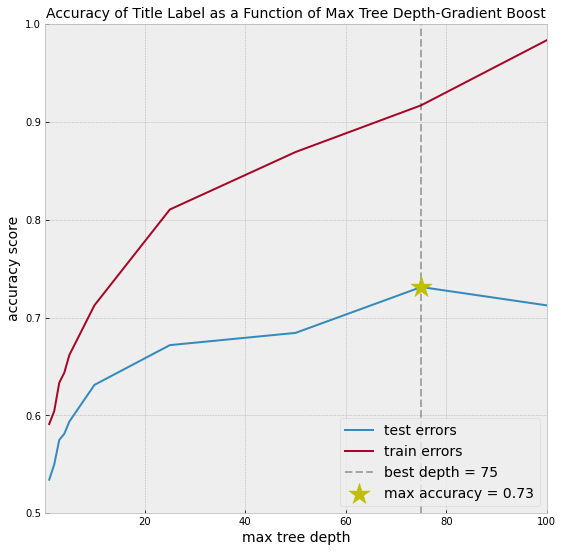

In [36]:
fig, ax=plt.subplots(figsize=(9,9))
plt.style.use('bmh')
ax.plot(depths, test_depths, label = 'test errors')
ax.plot(depths, train_depths, label = 'train errors')
#ax.plot(depths, train_scores, label = 'validation scores')
ax.set_xlabel('max tree depth', fontsize=14)
ax.set_ylabel('accuracy score', fontsize=14)
ax.set_title('Accuracy of Title Label as a Function of Max Tree Depth-Gradient Boost', fontsize=14)
ax.set_xlim(0.1, 100)
ax.set_ylim(0.5, 1)
ax.scatter(depths[test_depths.index(max(test_depths))], max(test_depths), label = f'max accuracy = {max(test_depths)[0]:.2f}', s= 500, color = 'y', marker = '*', zorder=4)
plt.axvline(depths[test_depths.index(max(test_depths))], label = f'best depth = {depths[test_depths.index(max(test_depths))]}', color = 'k', linestyle = 'dashed', alpha=0.3)

plt.legend(loc = 4, fontsize=14);
#plt.savefig('grad_boost/Title_depth_grad_boost', bbox_inches='tight')

In [35]:
N_ESTIMATORS = 100
subsamples=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
test_port=[]
train_port=[]
for portion in subsamples:
    model = GradientBoostingClassifier(learning_rate=0.01, 
                                  n_estimators=N_ESTIMATORS, #boosting stages to perform
                                  max_depth=75, subsample=portion)
    model.fit(X_train, np.array(y_train).ravel())
    test_port.append(model.score(X_test, np.array(y_test)).ravel())
    train_port.append(model.score(X_train, np.array(y_train).ravel()))

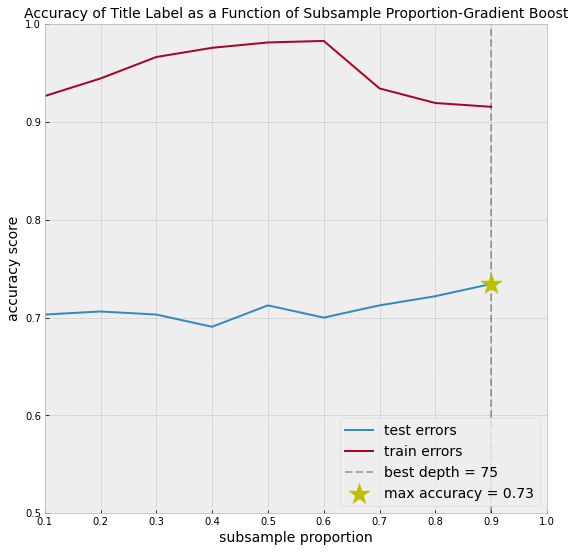

In [39]:
fig, ax=plt.subplots(figsize=(9,9))
plt.style.use('bmh')
ax.plot(subsamples, test_port, label = 'test errors')
ax.plot(subsamples, train_port, label = 'train errors')
#ax.plot(depths, train_scores, label = 'validation scores')
ax.set_xlabel('subsample proportion', fontsize=14)
ax.set_ylabel('accuracy score', fontsize=14)
ax.set_title('Accuracy of Title Label as a Function of Subsample Proportion-Gradient Boost', fontsize=14)
ax.set_xlim(0.1, 1)
ax.set_ylim(0.5, 1)
ax.scatter(subsamples[test_port.index(max(test_port))], max(test_port), label = f'max accuracy = {max(test_port)[0]:.2f}', s= 500, color = 'y', marker = '*', zorder=4)
plt.axvline(subsamples[test_port.index(max(test_port))], label = f'best depth = {depths[test_port.index(max(test_port))]}', color = 'k', linestyle = 'dashed', alpha=0.3)

plt.legend(loc = 4, fontsize=14);
plt.savefig('grad_boost/Title_subsamples_grad_boost', bbox_inches='tight')

In [ ]:
n_est=[50, 100, 250, 500, 1000, 2000, 4000]
rates=[0.1,0.01, 0.01, 0.01, 0.001, 0.001, 0.001]
test_n_est=[]
train_n_est=[]
for l_r, est in zip(rates, n_est):
    model = GradientBoostingClassifier(learning_rate=l_r, 
                                  n_estimators=n_est, #boosting stages to perform
                                  max_depth=75, subsample=0.8)
    model.fit(X_train, np.array(y_train).ravel())
    test_n_est.append(model.score(X_test, np.array(y_test)).ravel())
    train_n_est.append(model.score(X_train, np.array(y_train).ravel()))